In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from os.path import join, splitext
from collections import Counter
from sklearn.neighbors import KDTree

from skimage import io

from starfish.intensity_table.intensity_table import IntensityTable

In [2]:
nuc_filename = 'nucleiNuclei.csv'
nuc_df = pd.read_csv(nuc_filename)

In [3]:
# Get image filepaths
folder_path = '.'
#file_paths = glob.glob(join(folder_path, "*.ome.tif"))

In [4]:
def assign_spots(im_df, intensity_table, thresh):

    x_coords = im_df.Location_Center_X
    y_coords = im_df.Location_Center_Y

    coords = np.array([list(a) for a in zip(x_coords, y_coords)])

    kdt = KDTree(coords)

    spot_x_coords = intensity_table.x.values
    spot_y_coords = intensity_table.y.values

    spot_coords = np.array([list(a) for a in zip(spot_x_coords, spot_y_coords)])

    dist, ind = kdt.query(spot_coords, k=1)

    spot_mask = dist < thresh;

    good_spots_ind = ind[spot_mask]

    spot_counts = Counter(good_spots_ind)
    
    # Get the spots per cell
    spots_per_cell = [None] * len(spot_counts)
    for i, k in enumerate(spot_counts):
        gfp = im_df[im_df.ObjectNumber == (k + 1)].Intensity_MeanIntensity_GFP.as_matrix()[0]
        spots_per_cell[i] = (k, spot_counts[k], gfp)

    return spots_per_cell

In [5]:
image_df = pd.read_csv('nucleiImage.csv')

In [11]:
all_spot_counts = pd.DataFrame(columns=['image_idx', 'cell_idx', 'n_spots', 'gfp'])


for index, row in image_df.iterrows():
    # Get the intensity table name
    file_name = join(folder_path, row.FileName_DNA.split('_n')[0])
    file_name_prefix, target, suffix = file_name.split('_')
    pos, ext = suffix.split('.')
    intensity_table_name = '%s_p%s' % (file_name_prefix, pos)
    intensity_table_path = join(intensity_table_name)

    # Import the spots
    intensity_table = IntensityTable.load(intensity_table_path)

    im_df = nuc_df[nuc_df.ImageNumber == row.ImageNumber]
    
    spot_counts = assign_spots(im_df=im_df, intensity_table=intensity_table, thresh=200)
    
    for cell in spot_counts:
        all_spot_counts.loc[len(all_spot_counts)] = [row.ImageNumber, cell[0], cell[1], cell[2]]
    


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


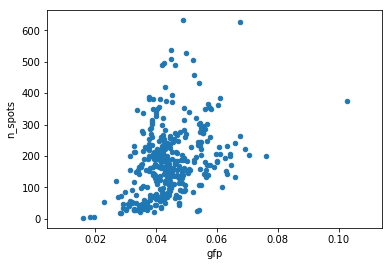

In [8]:
ax = all_spot_counts.plot.scatter(x='gfp',y='n_spots')

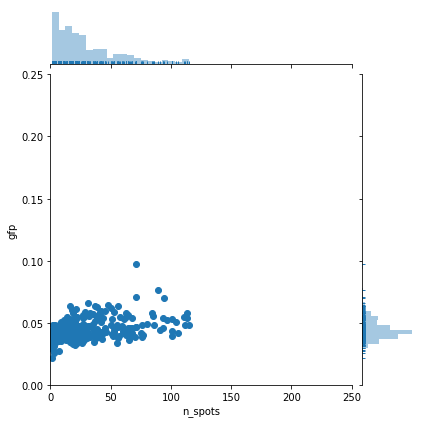

In [9]:
ax = sns.jointplot(x='n_spots', y='gfp', data=all_spot_counts, ylim=(0,0.25), xlim=(0,250), marginal_kws=dict(bins=20, rug=True))


In [13]:
all_spot_counts.to_csv('WT_ISP-2018-11-02-09-49-00-0002.csv')

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


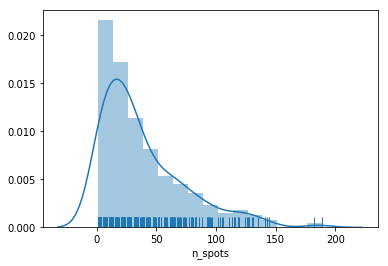

In [15]:
sns.distplot(all_spot_counts.n_spots, rug=True);

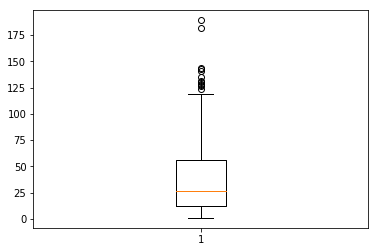

In [12]:
plt.boxplot(all_spot_counts.n_spots);